<a href="https://colab.research.google.com/github/hughesymendes/TIC-27491137/blob/Dip3_model/dip3_sampleSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve

!pip install exoplanet

!pip install pymc3==3.8

!pip install corner

     |████████████████████████████████| 512kB 2.7MB/s 
     |████████████████████████████████| 25.2MB 166kB/s 
     |████████████████████████████████| 4.5MB 35.7MB/s 
     |████████████████████████████████| 235kB 39.9MB/s 
     |████████████████████████████████| 2.7MB 42.6MB/s 
  Created wheel for astroquery: filename=astroquery-0.4-cp36-none-any.whl size=3582510 sha256=799dba5f4fbdb4126a97d58c991f0b37cd69986630d0e95210e3291032a2b31e
  Stored in directory: /root/.cache/pip/wheels/a3/6d/9d/f6ceddc68de0e4b7a64b56d6e8c8075e6ef6377ec9c05ce128
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96458 sha256=46d2ba528c5e07b7326e00a7deae20a74514db4a9208467f65717946be699958
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
  Created wheel for fbpca: filename=fbpca-1.0-cp36-none-any.whl size=11376 sha256=5a46487255ed130c5edf60eb9f44607e7cd66251729af46acdb90a568aa2aae9
  Stored in directory: /root/.cache/

/usr/local/lib/python3.6/dist-packages/lightkurve/search.py:233: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


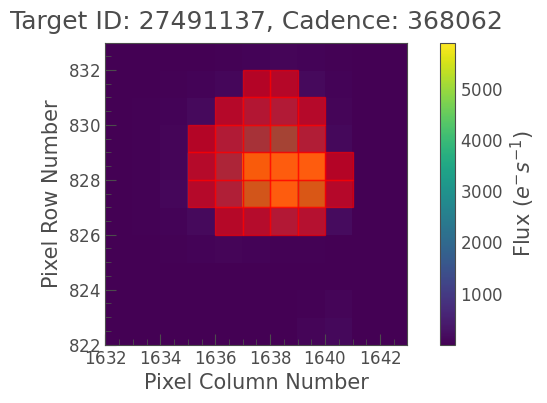

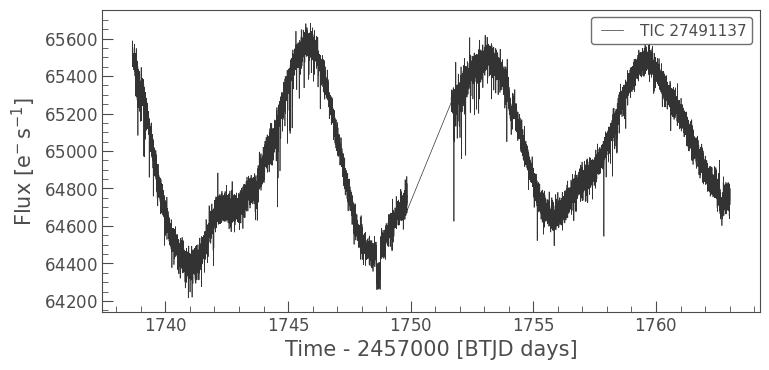

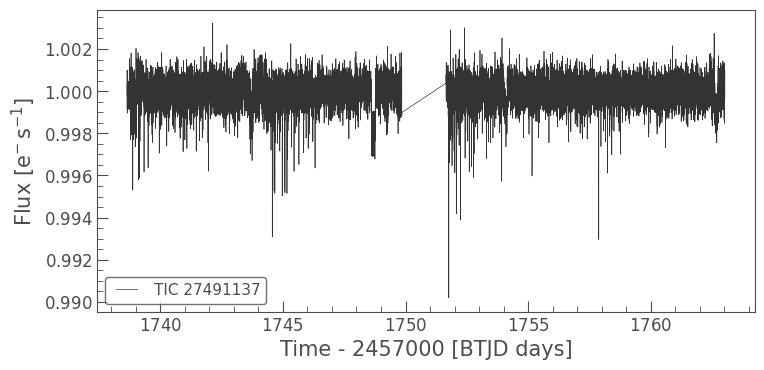

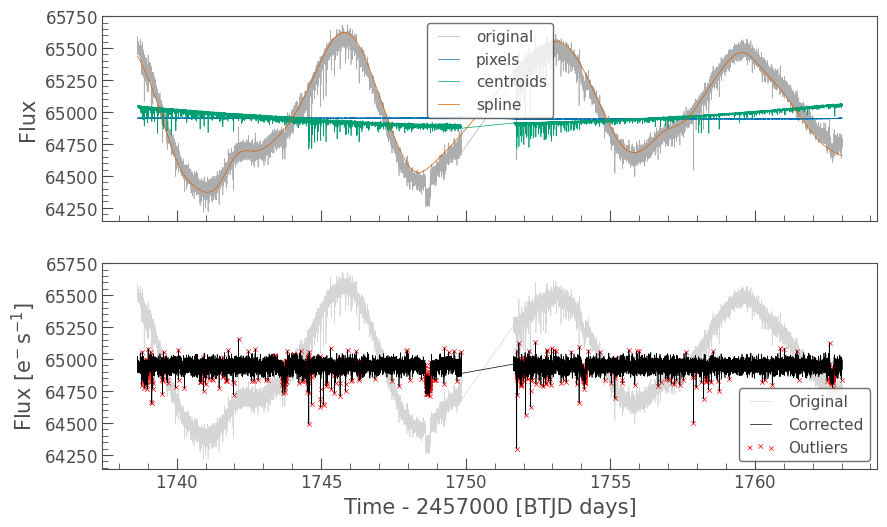

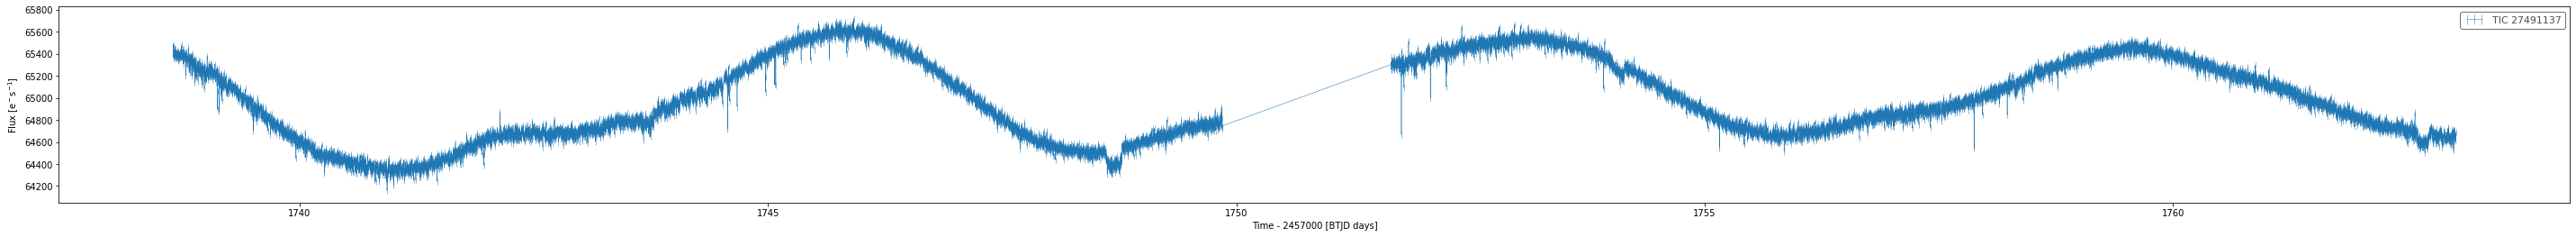

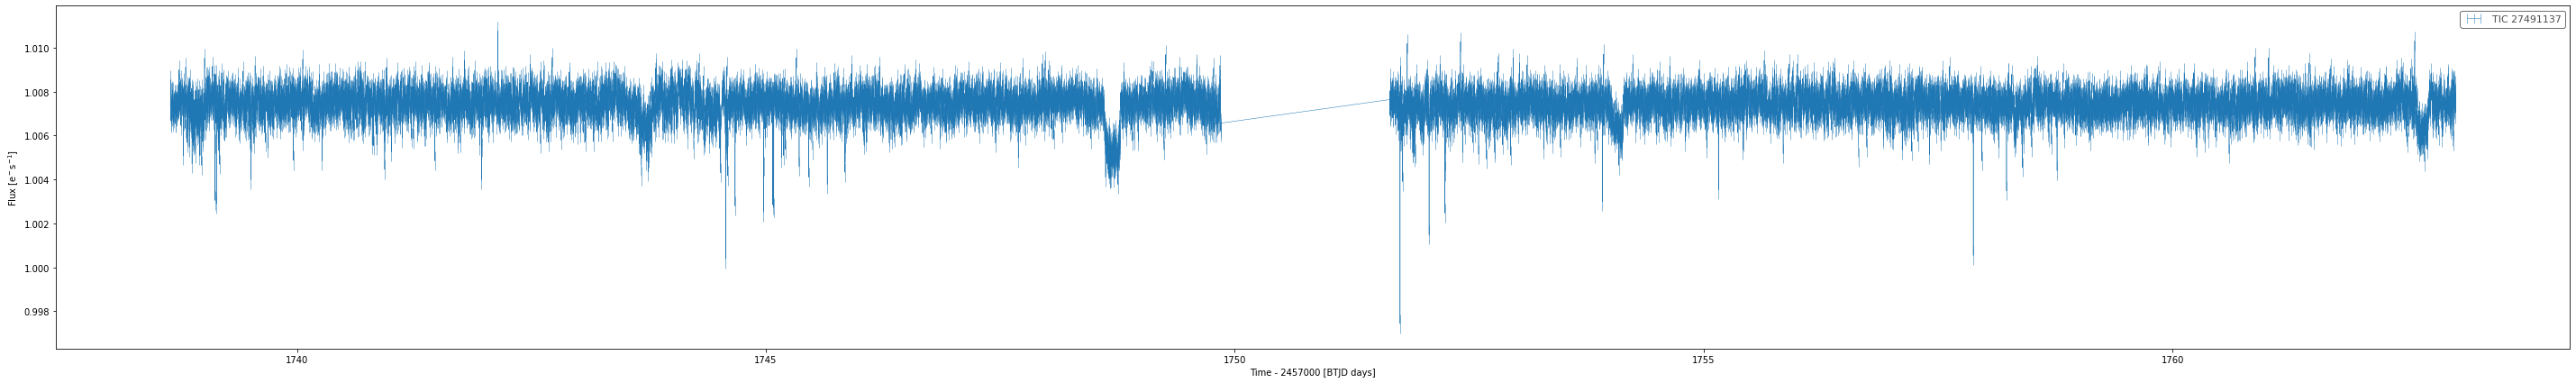

In [2]:


import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#downloading data from MAST
tpf = search_targetpixelfile("TIC 27491137").download()
aper = tpf.create_threshold_mask()
tpf.plot(aperture_mask = aper, mask_color = "red")

#Creating Lightcurve from TPF
lc = tpf.to_lightcurve()

#Masking out Argabrightening events
mask = np.isfinite(lc.flux_err)
clipped = lc[mask]

clipped.plot()

flc = clipped.flatten(window_length = 1001).plot()

pixels = tpf.flux[mask][:, ~aper]
dm1 = lk.DesignMatrix(pixels, name='pixels').pca(3).append_constant()

# We'll do a 3D low order polynomial in TIME, COLUMN CENTROID and ROW CENTROID:

r, c = tpf[mask].estimate_centroids()
r, c = r - np.median(r), c - np.median(c)


t = (lc[mask].cadenceno - np.median(lc.cadenceno))/(len(lc.time))


dm2 = lk.DesignMatrix(np.vstack([r, c, r*c, r**2, c**2, r**2*c, c**2*r, r**2*c**2,
                                t*r, t*c, t*r*c, t*r**2, t*c**2, t*r**2*c, t*c**2*r, t*r**2*c**2]).T, name='centroids')

spline = lk.designmatrix.create_spline_matrix(lc[mask].time, n_knots=35)

dm = lk.DesignMatrixCollection([dm1, dm2, spline])

# Make a very hacky cadence mask:
b = lc[mask].flatten(1001).bin(10)
_, m = b.remove_outliers(3, return_mask=True)
cadence_mask = np.interp(lc[mask].time, b.time, m) != 0

#Tried to make a mask by adding all the areas that i wanted to mask, however it errored out saying needed to be 2D?
#mask = (clipped[3300:3900], clipped[7100:7350], clipped[9500:10000], clipped[15700:]) = True

r = lk.RegressionCorrector(lc[mask])
r.correct(dm, sigma=3., cadence_mask=~cadence_mask)

r.diagnose()

# Remove INSTRUMENT systematics
corr = (r.diagnostic_lightcurves['pixels'] + r.diagnostic_lightcurves['centroids']).flux
corr -= np.median(corr)
clc = (lc[mask] - corr)

fig, ax = plt.subplots(figsize=(50, 4))
(clc).errorbar(ls='-', ax=ax)

# Divide through by STELLAR flux
stellar_flux = r.diagnostic_lightcurves['spline'].flux + np.median(clc.flux)

fig, ax = plt.subplots(figsize=(50, 7))
(clc/stellar_flux).errorbar(ls='-', ax=ax)

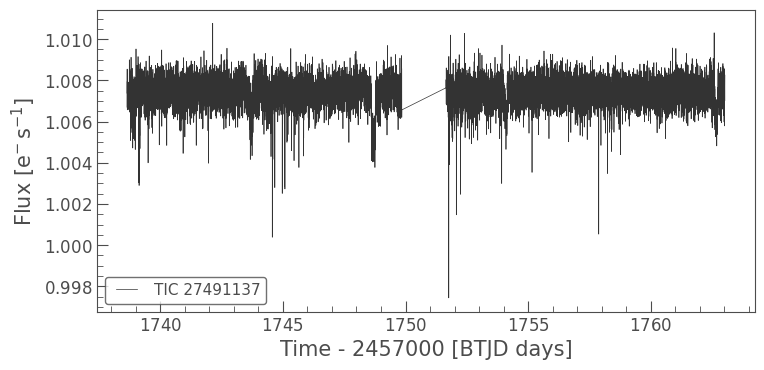

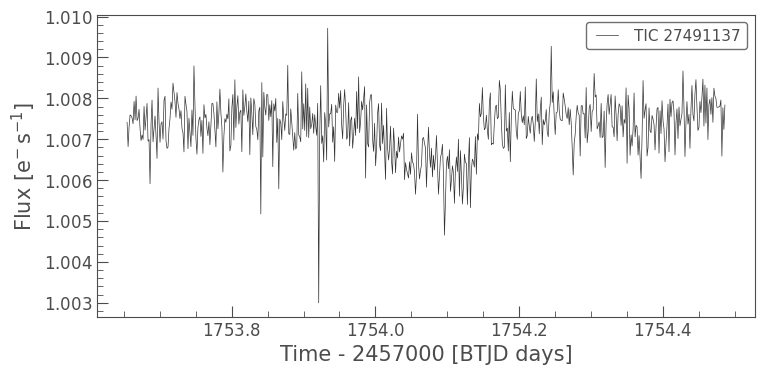

In [6]:
clean_lc = (clc/stellar_flux)
clean_lc.plot()

dip = clean_lc[9500:10100]
dip.plot()

dx = np.append( np.array( [], dtype="float64" ),dip.time )
dy = np.append( np.array( [], dtype="float64" ), dip.flux - 1.0075 )
dy_err = np.append( np.array( [], dtype="float64" ), dip.flux_err )

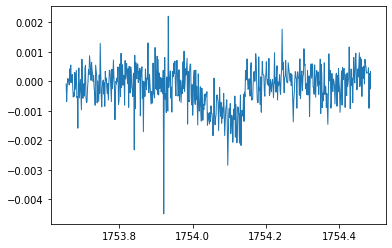

In [7]:
plt.plot(dx, dy, color="C0", lw=1)

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [TransitLength, radius_p, cot, m_star, r_star, period]


message: Optimization terminated successfully.
logp: -15383983218.364958 -> 17.062636228417


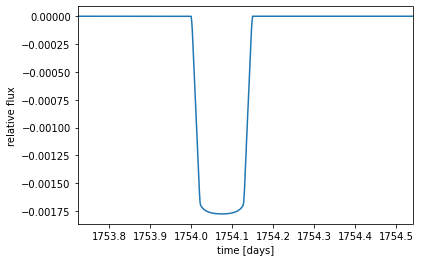

In [11]:
import exoplanet as xo
import pymc3 as pm


with pm.Model() as model:

  P = pm.Uniform("period", lower=7, upper=11, testval=10, shape=1)
  radius_s = pm.Normal("r_star", mu=0.772148, sd= 0.0454673,testval= 0.78)
  mass_s = pm.Normal("m_star", mu=0.87, sd=0.108032, testval= 0.87)
  cot = pm.Normal("cot", mu=1754.075, sd=0.01, testval= 1754.10)
  radius_p = pm.Normal("radius_p", mu=0.032, sd=0.0002, testval=0.032)
  TransitLength = pm.Normal("TransitLength", mu=0.02, sd=0.01, testval= 1754.10)

  
  # The light curve calculation requires an orbit
  orbit = xo.orbits.KeplerianOrbit(period=P, t0=cot, r_star=radius_s, m_star=mass_s)

  # Compute a limb-darkened light curve using starry
  t = np.linspace(1753.72392345,1754.53919067, 600)


  #found values from a paper for Kepler and TESS that gives a=0.4984, b= 0.1939 (using quadratic law).
  # 'u' seems to be linear but is only given as one value whereas 'u' here is 2D so I've input values 
  # In between the two closest stellar temps. paper-- https://arxiv.org/pdf/0912.2274.pdf
  u = [0.05, 0.1]
  light_curve = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=radius_p, t=t, texp=TransitLength)
  )
  map_soln = xo.optimize(start=model.test_point)
  xo.eval_in_model(light_curve)
  # Note: the `eval` is needed because this is using Theano in
  # the background

plt.plot(t, xo.eval_in_model(light_curve, model=model, point=map_soln))
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
optimizing logp for variables: [b, r, u, logp, t0, mean, r_star]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 3443.476835242433 -> 3605.939985602915


IndexError: ignored

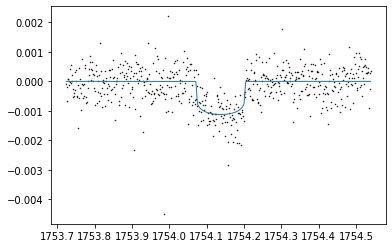

In [12]:
import pymc3 as pm




with pm.Model() as model:

    r_star = pm.Normal("r_star", mu=0.772148, sd= 0.0454673,testval= 0.78)

    # The baseline flux
    mean = pm.Normal("mean", mu=0, sd=0.0001)

    # The time of a reference transit for each planet
    #Mu seems to be centre of transit.
    #For random.uniform "Samples are uniformly distributed over the half-open interval [low, high) (includes low, but excludes high)"
    t0 = pm.Normal("t0", mu=1754.10, sd=0.01, shape=1)

    # The log period; also tracking the period itself
    logP = pm.Uniform("logp", lower=0, upper=3, testval=1, shape = 1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.525, 0.215]))

    #r is in units of R_star which is units of R_sun
    r = pm.Uniform("r", lower=0.01, upper=0.04, shape=1)
    b = xo.distributions.ImpactParameter("b", ror=r/r_star, shape=1, testval=0.1)

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = dy
    
    # The likelihood function assuming known Gaussian uncertainty- 
    #Likelihood function is a function that represents the distribution from an actual test sample
    pm.Normal("obs", mu=light_curve, sd=dy_err, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    # Posterior distribution is usually given as Prior*Likelihood
    map_soln = xo.optimize(start=model.test_point)


plt.plot(t, y, ".k", ms=1, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(1)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

In [13]:
#random.seed will create a random first instance of data where there is no prior data
#Because we're using MCMC methods to now sample from our data i believe that it creates
#an initial value for the sample to then be drawn ontop of from our model. 
#42 is like the ID for this seed, ie whenever 42 is passed the same result for the seed is achieved (reproducability)

np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (4 chains in 1 job)
NUTS: [b, r, u, logp, t0, mean, r_star]
Sampling chain 0, 0 divergences:   0%|          | 0/6000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either i

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
period[0],8.238,3.708,4.469,16.358,0.083,0.064,1978.0,1664.0,2583.0,1574.0,1.0
t0[0],1754.138,0.002,1754.135,1754.141,0.000,0.000,4889.0,4887.0,6834.0,3048.0,1.0
r[0],0.032,0.001,0.029,0.034,0.000,0.000,3543.0,3471.0,3675.0,3390.0,1.0
b[0],0.393,0.225,0.024,0.756,0.004,0.003,3036.0,2657.0,2344.0,1763.0,1.0
u[0],0.305,0.232,0.000,0.729,0.003,0.002,6968.0,5865.0,7071.0,6488.0,1.0
u[1],0.235,0.308,-0.293,0.818,0.003,0.002,7900.0,7900.0,7536.0,6081.0,1.0
mean,-0.000,0.000,-0.000,0.000,0.000,0.000,9173.0,7975.0,9186.0,7443.0,1.0


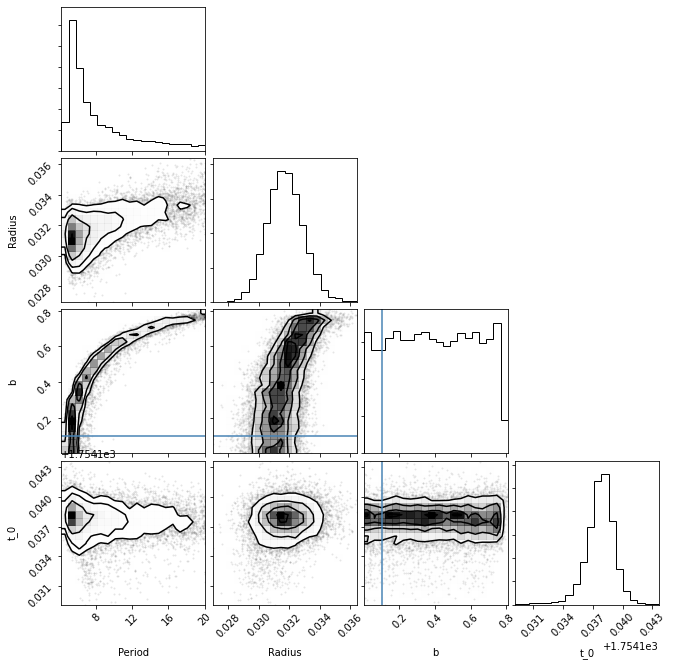

In [15]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "r", "b", "t0"])
truth = np.concatenate(xo.eval_in_model([period, r, b, t0], model.test_point, model=model))
corner.corner(
    samples, truths=truth, labels=["Period", "Radius", "b", "t_0"]
);